# Getting Data

In [95]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd

In [96]:
client_id = 'b05478021f3c4e73bbbd0482e81a3396'
client_secret = '535562f03be14a998dcd97448d5322e8'

#Authentication - without user
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [97]:
# Chill Car - Rap, Bollywood Beats, Lit Songs, Fam Mix, Chill - Pop, Nostalgia, Epic Vibes, Nostalgic EDM 
playlist_links = ["https://open.spotify.com/playlist/39yrrZvXXVTQjnv41mLZE5?si=043d2b062b4748c7",
                  "https://open.spotify.com/playlist/12p5ArAxY6r3QOtNATi7Mx?si=0e44c2c5c12d4f45",
                  "https://open.spotify.com/playlist/4KhumTd9QyJM3RUvAzSJh7?si=edc7bcc04f1c43a9",
                  "https://open.spotify.com/playlist/1OzHjXm9IwK7dlQk1mXP2N?si=05d4cd76d85f47df",
                  "https://open.spotify.com/playlist/2W4rSltujQSUyXT3Yu03ga?si=7ff0dd18a47b4517",
                  "https://open.spotify.com/playlist/4Xwamd29v8Lij8tsP9jslm?si=8ed5a2c219624e3c",
                  "https://open.spotify.com/playlist/2K1GpNap0DQs2BsTwbGGPI?si=bcea1ac135924f04",
                  "https://open.spotify.com/playlist/0KAbqWJrRxqhaoYKVu2hDE?si=0ebdb168c8634f40"
                ]
playlist_URIs = [playlist_link.split("/")[-1].split("?")[0] for playlist_link in playlist_links]

In [98]:
def get_playlist_tracks(playlist_id):
    results = sp.playlist_tracks(playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

In [100]:
song_data = []
seen_songs = set()
for playlist_URI in playlist_URIs:
    tracks = get_playlist_tracks(playlist_URI)
    for track in tracks:
        # URI
        track_uri = track["track"]["uri"]
        
        # Skip duplicate songs
        if track_uri in seen_songs:
            print(track["track"]["name"])
            # Update the playlist URIs for the existing song
            existing_song_index = next((index for index, song in enumerate(song_data) if song[0] == track_uri), None)
            if existing_song_index is not None:
                song_data[existing_song_index][-1].add(playlist_URI)
            continue
        
        # Add song URI to seen_songs set
        seen_songs.add(track_uri)
        
        # Track name
        track_name = track["track"]["name"]
        
        # Main Artist
        artists = []
        artist_genres = set()
        
        for artist in track["track"]["artists"]:
            artist_uri = artist["uri"]
            artist_info = sp.artist(artist_uri)
            artists.append(artist['name'])
            artist_genres.update(artist_info["genres"])

        # Album
        album = track["track"]["album"]["name"]
        
        # release date
        release_date = track["track"]["album"]["release_date"][0:4]

        # Popularity of the track
        track_pop = track["track"]["popularity"]
        
        # Audio Features
        audio_features = sp.audio_features(track_uri)[0]
        selected_features = {
            'danceability': audio_features['danceability'],
            'energy': audio_features['energy'],
            'key': audio_features['key'],
            'loudness': audio_features['loudness'],
            'speechiness': audio_features['speechiness'],
            'acousticness': audio_features['acousticness'],
            'instrumentalness': audio_features['instrumentalness'],
            'liveness': audio_features['liveness'],
            'valence': audio_features['valence'],
            'tempo': audio_features['tempo']
        }
        
        song_data.append([track_name, artists, list(artist_genres), track_pop, release_date] + list(selected_features.values()) + [{playlist_URI}])

# Create the dataframe
columns = ['Track Name', 'Artist Name', 'Artist Genres', 'Track Popularity', 'Release Date'] + list(selected_features.keys()) + ['Playlist URIs']
df = pd.DataFrame(song_data, columns=columns)

In [101]:
df

,Track Name,Artist Name,Artist Genres,Track Popularity,Release Date,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,Playlist URIs
0,Shiva (with JID & EARTHGANG feat. Benji. & Jur...,"[Spillage Village, JID, EARTHGANG, Benji., Jur...","[underground hip hop, rap, hip hop, indie hip ...",49,2020,0.442,0.770,11,-4.369,0.5010,0.109000,0.000000,0.4150,0.341,192.179,{39yrrZvXXVTQjnv41mLZE5}
1,All Over You,[Majid Jordan],[canadian contemporary r&b],1,2018,0.797,0.500,0,-6.964,0.0354,0.057900,0.000000,0.1220,0.492,106.957,{39yrrZvXXVTQjnv41mLZE5}
2,Our Time,[Lil Tecca],"[pluggnb, melodic rap, rap]",80,2020,0.895,0.439,5,-12.142,0.3190,0.199000,0.000000,0.0683,0.633,109.988,{39yrrZvXXVTQjnv41mLZE5}
3,Baby $hit,"[Freddie Gibbs, The Alchemist]","[alternative hip hop, underground hip hop, rap...",52,2020,0.599,0.629,2,-11.325,0.3810,0.665000,0.016500,0.4470,0.577,130.346,{39yrrZvXXVTQjnv41mLZE5}
4,Magic In The Hamptons (feat. Lil Yachty),"[Social House, Lil Yachty]","[trap, melodic rap, atl hip hop, rap]",77,2018,0.769,0.479,1,-5.339,0.0385,0.660000,0.000000,0.0914,0.803,96.051,{39yrrZvXXVTQjnv41mLZE5}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,On & On,"[Cartoon, Daniel Levi]","[gaming edm, estonian pop]",77,2015,0.451,0.692,11,-4.741,0.0398,0.287000,0.000000,0.1150,0.423,174.122,{0KAbqWJrRxqhaoYKVu2hDE}
826,Cradles,[Sub Urban],[modern indie pop],73,2019,0.537,0.586,6,-1.864,0.3140,0.265000,0.000070,0.1750,0.624,79.056,{0KAbqWJrRxqhaoYKVu2hDE}
827,Invincible,[Deaf Kev],[gaming edm],63,2015,0.560,0.970,5,-2.858,0.0510,0.000154,0.718000,0.0763,0.269,100.090,{0KAbqWJrRxqhaoYKVu2hDE}
828,Nekozilla,[Different Heaven],[gaming edm],28,2015,0.745,0.905,6,-5.182,0.0473,0.000387,0.148000,0.0699,0.378,128.030,{0KAbqWJrRxqhaoYKVu2hDE}


# Exploring Data

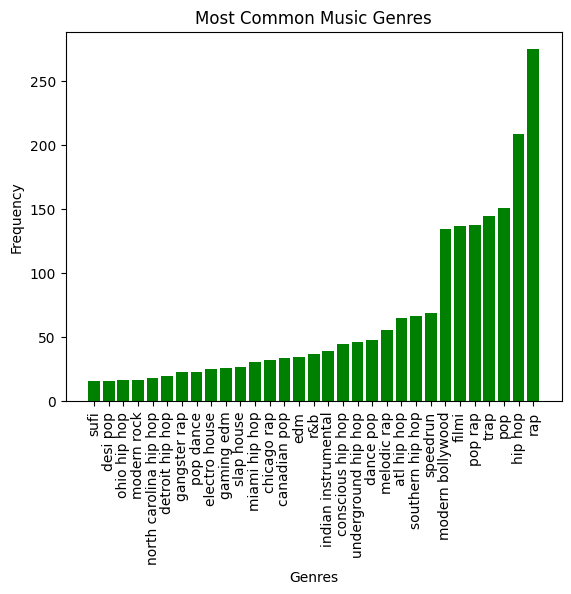

In [102]:
import matplotlib.pyplot as plt

genre_freq = {}

for genre_list in df['Artist Genres']:
    for g in genre_list:
        if g in genre_freq:
            genre_freq[g] += 1
        else:
            genre_freq[g] = 1

sorted_data = dict(sorted(genre_freq.items(), key=lambda x: x[1]))

genre_freq_filtered = {genre: frequency for genre, frequency in sorted_data.items() if frequency > 15}

plt.bar(genre_freq_filtered.keys(), genre_freq_filtered.values(), color='g')

# Set labels and title
plt.xlabel('Genres')
plt.ylabel('Frequency')
plt.title('Most Common Music Genres')

# Rotate the genre labels for better visibility
plt.xticks(rotation=90)

# Display the histogram
plt.show()

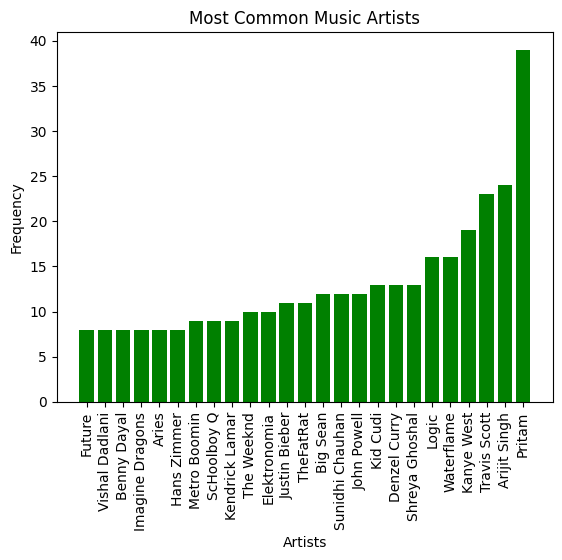

In [103]:
import re

artist_freq = {}

# Filter out artists' names with special characters
pattern = re.compile(r'^[a-zA-Z0-9\s]+$')  # Regular expression pattern to match alphanumeric characters and spaces

for artists in df['Artist Name']:
    for artist in artists:
        if re.match(pattern, artist):
            if artist in artist_freq:
                artist_freq[artist] += 1
            else:
                artist_freq[artist] = 1


sorted_data = dict(sorted(artist_freq.items(), key=lambda x: x[1]))

genre_freq_filtered = {genre: frequency for genre, frequency in sorted_data.items() if frequency > 7}

plt.bar(genre_freq_filtered.keys(), genre_freq_filtered.values(), color='g')

# Set labels and title
plt.xlabel('Artists')
plt.ylabel('Frequency')
plt.title('Most Common Music Artists')

# Rotate the genre labels for better visibility
plt.xticks(rotation=90)

# Display the histogram
plt.show()

# Processing

In [117]:
df['Rap Genre'] = df['Artist Genres'].apply(lambda x: 1 if re.search('|'.join(['drill', 'rap', 'hip hop']), ' '.join(x)) else 0)
df['Pop Genre'] = df['Artist Genres'].apply(lambda x: 1 if re.search('|'.join(['pop', 'dance', 'broadway', 'reggae fusion']), ' '.join(x)) else 0)
df['Rock Genre'] = df['Artist Genres'].apply(lambda x: 1 if re.search('|'.join(['rock', 'metalcore']), ' '.join(x)) else 0)
df['R&B Genre'] = df['Artist Genres'].apply(lambda x: 1 if re.search('|'.join(['r&b', 'blues', 'rhythm', 'dixieland', 'harlem']), ' '.join(x)) else 0)
df['Bollywood Genre'] = df['Artist Genres'].apply(lambda x: 1 if re.search('|'.join(['filmi', 'bollywood', 'indian', 'mollywood']), ' '.join(x)) else 0)
df['EDM Genre'] = df['Artist Genres'].apply(lambda x: 1 if re.search('|'.join(['edm', 'electro', 'nordic house', 'speedrun', 'gaming edm', 'dubstep', 'brostep']), ' '.join(x)) else 0)
df['Soundtrack Genre'] = df['Artist Genres'].apply(lambda x: 1 if re.search('|'.join(['orchestra', 'soundtrack', 'movie', 'hollywood', 'anime lo-fi']), ' '.join(x)) else 0)

In [118]:
# Tracks with genres but unlisted from above
df.loc[(df.iloc[:, 16:].sum(axis=1) == 0) & (df['Artist Genres'].map(len) != 0)]

,Track Name,Artist Name,Artist Genres,Track Popularity,Release Date,danceability,energy,key,loudness,speechiness,...,valence,tempo,Playlist URIs,Rap Genre,Pop Genre,R&B Genre,Bollywood Genre,EDM Genre,Soundtrack Genre,Rock Genre
9,Tetris,[Derek King],[slow game],51,2018,0.791,0.581,1,-7.750,0.0790,...,0.130,99.034,{39yrrZvXXVTQjnv41mLZE5},0,0,0,0,0,0,0
490,Fire Again,"[VALORANT, Ashnikko]","[alt z, video game music, escape room]",68,2022,0.516,0.789,0,-3.678,0.1630,...,0.266,99.998,{4KhumTd9QyJM3RUvAzSJh7},0,0,0,0,0,0,0
519,Over the Rainbow,[Israel Kamakawiwo'ole],"[hawaiian, ukulele]",76,2001,0.671,0.153,0,-13.569,0.0404,...,0.658,85.600,{1OzHjXm9IwK7dlQk1mXP2N},0,0,0,0,0,0,0
622,Your Woman,[White Town],[derby indie],70,1997,0.815,0.605,5,-9.118,0.0368,...,0.795,102.642,{2W4rSltujQSUyXT3Yu03ga},0,0,0,0,0,0,0
768,Hello,[OMFG],[otacore],64,2014,0.844,0.864,7,-4.483,0.0348,...,0.796,104.997,{0KAbqWJrRxqhaoYKVu2hDE},0,0,0,0,0,0,0


# Visualize

In [127]:
df.columns

Index(['Track Name', 'Artist Name', 'Artist Genres', 'Track Popularity',
       'Release Date', 'danceability', 'energy', 'key', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'Playlist URIs', 'Rap Genre', 'Pop Genre',
       'R&B Genre', 'Bollywood Genre', 'EDM Genre', 'Soundtrack Genre',
       'Rock Genre'],
      dtype='object')

In [132]:
from sklearn.preprocessing import StandardScaler
x = df.iloc[:, 3:].drop("Playlist URIs", axis=1).values
x = StandardScaler().fit_transform(x) # normalizing the features

In [133]:
from sklearn.decomposition import PCA
pca_song = PCA(n_components=2)
principalComponents_songs = pca_song.fit_transform(x)

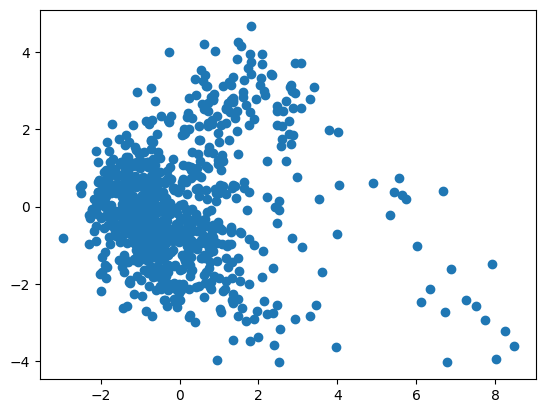

In [140]:
principal_song_df = pd.DataFrame(data = principalComponents_songs)

targets = ['Benign', 'Malignant']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = breast_dataset['label'] == target
    plt.scatter(principal_breast_Df.loc[indicesToKeep, 'principal component 1']
               , principal_breast_Df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)